In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from torch.optim import LBFGS, Adam
from tqdm import tqdm
import scipy.io

from util import *

In [2]:
seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

device = 'cuda:1'

In [3]:
data = scipy.io.loadmat('./cylinder_nektar_wake.mat')

In [4]:
U_star = data['U_star'] # N x 2 x T
P_star = data['p_star'] # N x T
t_star = data['t'] # T x 1
X_star = data['X_star'] # N x 2

N = X_star.shape[0]
T = t_star.shape[0]

# Rearrange Data 
XX = np.tile(X_star[:,0:1], (1,T)) # N x T
YY = np.tile(X_star[:,1:2], (1,T)) # N x T
TT = np.tile(t_star, (1,N)).T # N x T

UU = U_star[:,0,:] # N x T
VV = U_star[:,1,:] # N x T
PP = P_star # N x T

x = XX.flatten()[:,None] # NT x 1
y = YY.flatten()[:,None] # NT x 1
t = TT.flatten()[:,None] # NT x 1

u = UU.flatten()[:,None] # NT x 1
v = VV.flatten()[:,None] # NT x 1
p = PP.flatten()[:,None] # NT x 1

idx = np.random.choice(N*T,2500, replace=False)
x_train = x[idx,:]
y_train = y[idx,:]
t_train = t[idx,:]
u_train = u[idx,:]
v_train = v[idx,:]

x_train = torch.tensor(x_train, dtype=torch.float32, requires_grad=True).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32, requires_grad=True).to(device)
t_train = torch.tensor(t_train, dtype=torch.float32, requires_grad=True).to(device)
u_train = torch.tensor(u_train, dtype=torch.float32, requires_grad=True).to(device)
v_train = torch.tensor(v_train, dtype=torch.float32, requires_grad=True).to(device)

In [5]:
class QRes_block(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(QRes_block, self).__init__()
        self.H1 = nn.Linear(in_features=in_dim, out_features=out_dim)
        self.H2 = nn.Linear(in_features=in_dim, out_features=out_dim)
        self.act = nn.Sigmoid()
    
    def forward(self, x):
        x1 = self.H1(x)
        x2 = self.H2(x)
        return self.act(x1*x2 + x1)



class QRes(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, num_layer):
        super(QRes, self).__init__()
        self.N = num_layer-1
        self.inlayer = QRes_block(in_dim, hidden_dim)
        self.layers = get_clones(QRes_block(hidden_dim, hidden_dim), num_layer-1)
        self.outlayer = nn.Linear(in_features=hidden_dim, out_features=out_dim)

    def forward(self, x,y,t):
        src = torch.cat((x,y,t), dim=-1)
        src = self.inlayer(src)
        for i in range(self.N):
            src = self.layers[i](src)
        src = self.outlayer(src)
        return src
    

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

In [6]:
model = QRes(in_dim=3, hidden_dim=256, out_dim=2, num_layer=4).to(device)

model.apply(init_weights)
optim = LBFGS(model.parameters(), line_search_fn='strong_wolfe')
# optim = Adam(model.parameters(), lr=1e-3)

print(model)
print(get_n_params(model))

QRes(
  (inlayer): QRes_block(
    (H1): Linear(in_features=3, out_features=256, bias=True)
    (H2): Linear(in_features=3, out_features=256, bias=True)
    (act): Sigmoid()
  )
  (layers): ModuleList(
    (0-2): 3 x QRes_block(
      (H1): Linear(in_features=256, out_features=256, bias=True)
      (H2): Linear(in_features=256, out_features=256, bias=True)
      (act): Sigmoid()
    )
  )
  (outlayer): Linear(in_features=256, out_features=2, bias=True)
)
397314


/tmp/ipykernel_2453135/1630523777.py:34: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


In [7]:
loss_track = []

for i in tqdm(range(1000)):
    def closure():
        psi_and_p = model(x_train, y_train, t_train)
        psi = psi_and_p[:,0:1]
        p = psi_and_p[:,1:2]

        u = torch.autograd.grad(psi, y_train, grad_outputs=torch.ones_like(psi), retain_graph=True, create_graph=True)[0]
        v = - torch.autograd.grad(psi, x_train, grad_outputs=torch.ones_like(psi), retain_graph=True, create_graph=True)[0]

        u_t = torch.autograd.grad(u, t_train, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        u_x = torch.autograd.grad(u, x_train, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        u_y = torch.autograd.grad(u, y_train, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        u_xx = torch.autograd.grad(u, x_train, grad_outputs=torch.ones_like(u_x), retain_graph=True, create_graph=True)[0]
        u_yy = torch.autograd.grad(u, y_train, grad_outputs=torch.ones_like(u_y), retain_graph=True, create_graph=True)[0]

        v_t = torch.autograd.grad(v, t_train, grad_outputs=torch.ones_like(v), retain_graph=True, create_graph=True)[0]
        v_x = torch.autograd.grad(v, x_train, grad_outputs=torch.ones_like(v), retain_graph=True, create_graph=True)[0]
        v_y = torch.autograd.grad(v, y_train, grad_outputs=torch.ones_like(v), retain_graph=True, create_graph=True)[0]
        v_xx = torch.autograd.grad(v, x_train, grad_outputs=torch.ones_like(v_x), retain_graph=True, create_graph=True)[0]
        v_yy = torch.autograd.grad(v, y_train, grad_outputs=torch.ones_like(v_y), retain_graph=True, create_graph=True)[0]

        p_x = torch.autograd.grad(p, x_train, grad_outputs=torch.ones_like(p), retain_graph=True, create_graph=True)[0]
        p_y = torch.autograd.grad(p, y_train, grad_outputs=torch.ones_like(p), retain_graph=True, create_graph=True)[0]

        f_u = u_t + (u*u_x + v*u_y) + p_x - 0.01*(u_xx + u_yy) 
        f_v = v_t + (u*v_x + v*v_y) + p_y - 0.01*(v_xx + v_yy)

        loss = torch.mean((u - u_train)**2) + torch.mean((v - v_train)**2) + torch.mean(f_u**2) + torch.mean(f_v**2)

        loss_track.append(loss.item())

        optim.zero_grad()
        loss.backward()
        return loss

    optim.step(closure)

100%|██████████| 1000/1000 [33:02<00:00,  1.98s/it]


In [8]:
np.save('./ns_loss_qres.npy', loss_track)
torch.save(model.state_dict(), './ns_qres.pt')

loss_track[-1]

0.00022379893925972283

In [9]:
 # Test Data
snap = np.array([100])
x_star = X_star[:,0:1]
y_star = X_star[:,1:2]
t_star = TT[:,snap]

u_star = U_star[:,0,snap]
v_star = U_star[:,1,snap]
p_star = P_star[:,snap]

x_star = torch.tensor(x_star, dtype=torch.float32, requires_grad=True).to(device)
y_star = torch.tensor(y_star, dtype=torch.float32, requires_grad=True).to(device)
t_star = torch.tensor(t_star, dtype=torch.float32, requires_grad=True).to(device)


In [10]:
# with torch.no_grad():
psi_and_p = model(x_star, y_star, t_star)
psi = psi_and_p[:,0:1]
p_pred = psi_and_p[:,1:2]

u_pred = torch.autograd.grad(psi, x_star, grad_outputs=torch.ones_like(psi), retain_graph=True, create_graph=True)[0]
v_pred = - torch.autograd.grad(psi, y_star, grad_outputs=torch.ones_like(psi), retain_graph=True, create_graph=True)[0]

u_pred = u_pred.cpu().detach().numpy()
v_pred = v_pred.cpu().detach().numpy()
p_pred = p_pred.cpu().detach().numpy()

error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
error_v = np.linalg.norm(v_star-v_pred,2)/np.linalg.norm(v_star,2)
error_p = np.linalg.norm(p_star-p_pred,2)/np.linalg.norm(p_star,2)

In [11]:
error_p

4.451343078960015

In [12]:
error_p = np.linalg.norm(p_star-p_pred,1)/np.linalg.norm(p_star,1)
error_p

6.41231290359003

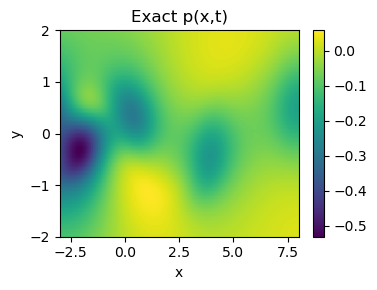

In [13]:
plt.figure(figsize=(4,3))
plt.imshow((p_star).reshape(50,100), extent=[-3,8,-2,2], aspect='auto')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Exact p(x,t)')
plt.colorbar()
plt.tight_layout()
plt.savefig('./ns_exact.png')
plt.show()

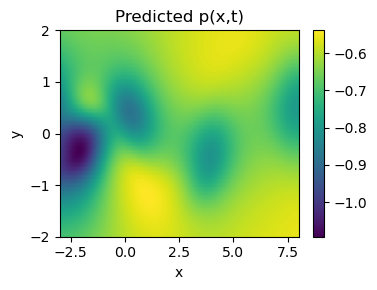

In [14]:
plt.figure(figsize=(4,3))
plt.imshow((p_pred).reshape(50,100), extent=[-3,8,-2,2], aspect='auto')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Predicted p(x,t)')
plt.colorbar()
plt.tight_layout()
plt.savefig('./ns_qres_pred.png')
plt.show()

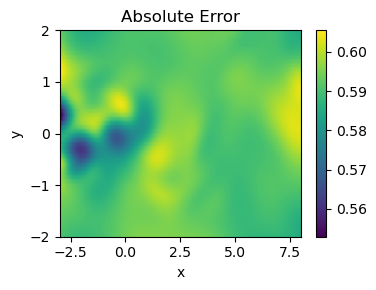

In [15]:
plt.figure(figsize=(4,3))
plt.imshow(np.abs(p_pred-p_star).reshape(50,100), extent=[-3,8,-2,2], aspect='auto')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Absolute Error')
plt.colorbar()
plt.tight_layout()
plt.savefig('./ns_qres_error.png')
plt.show()